In [ ]:
import yfinance as yf
import pandas as pd

tickers = [
    "AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "META", "NVDA", "JNJ", "V", "WMT",
    "JPM", "PG", "MA", "UNH", "DIS", "PYPL", "BAC", "VZ", "ADBE", "NFLX",
    "PFE", "KO", "INTC", "CMCSA", "PEP", "CSCO", "MRK", "T", "XOM", "NKE",
    "WFC", "ORCL", "ACN", "LLY", "TMO", "ABBV", "COST", "AVGO", "MDT", "QCOM",
    "TXN", "NEE", "HON", "UNP", "AMGN", "PM", "UPS", "MS", "IBM", "GS","EURUSD=X", "JPY=X", "GBPUSD=X", "AUDUSD=X", "CAD=X"

]


In [ ]:

try:
    data = yf.download(tickers, start="2018-01-01", end="2023-01-01")['Adj Close']
    print(data.head())
except Exception as e:
    print(f"An error occurred: {e}")

In [ ]:
data = data.dropna( how= 'any')
returns = data.pct_change().dropna()

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

future_returns = returns.shift(-1).dropna()

X = returns.iloc[:-1]
y = future_returns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.00041826394471774006


In [5]:
import numpy as np
from scipy.optimize import minimize

predicted_returns = model.predict(returns)

top_5_indices = np.argsort((predicted_returns.mean(axis=0)/predicted_returns.std(axis = 0)))[-5:]
top_5_stocks = returns.columns[top_5_indices]
selected_returns = returns[top_5_stocks]
selected_predicted_returns = pd.DataFrame(predicted_returns, columns=returns.columns)[top_5_stocks]



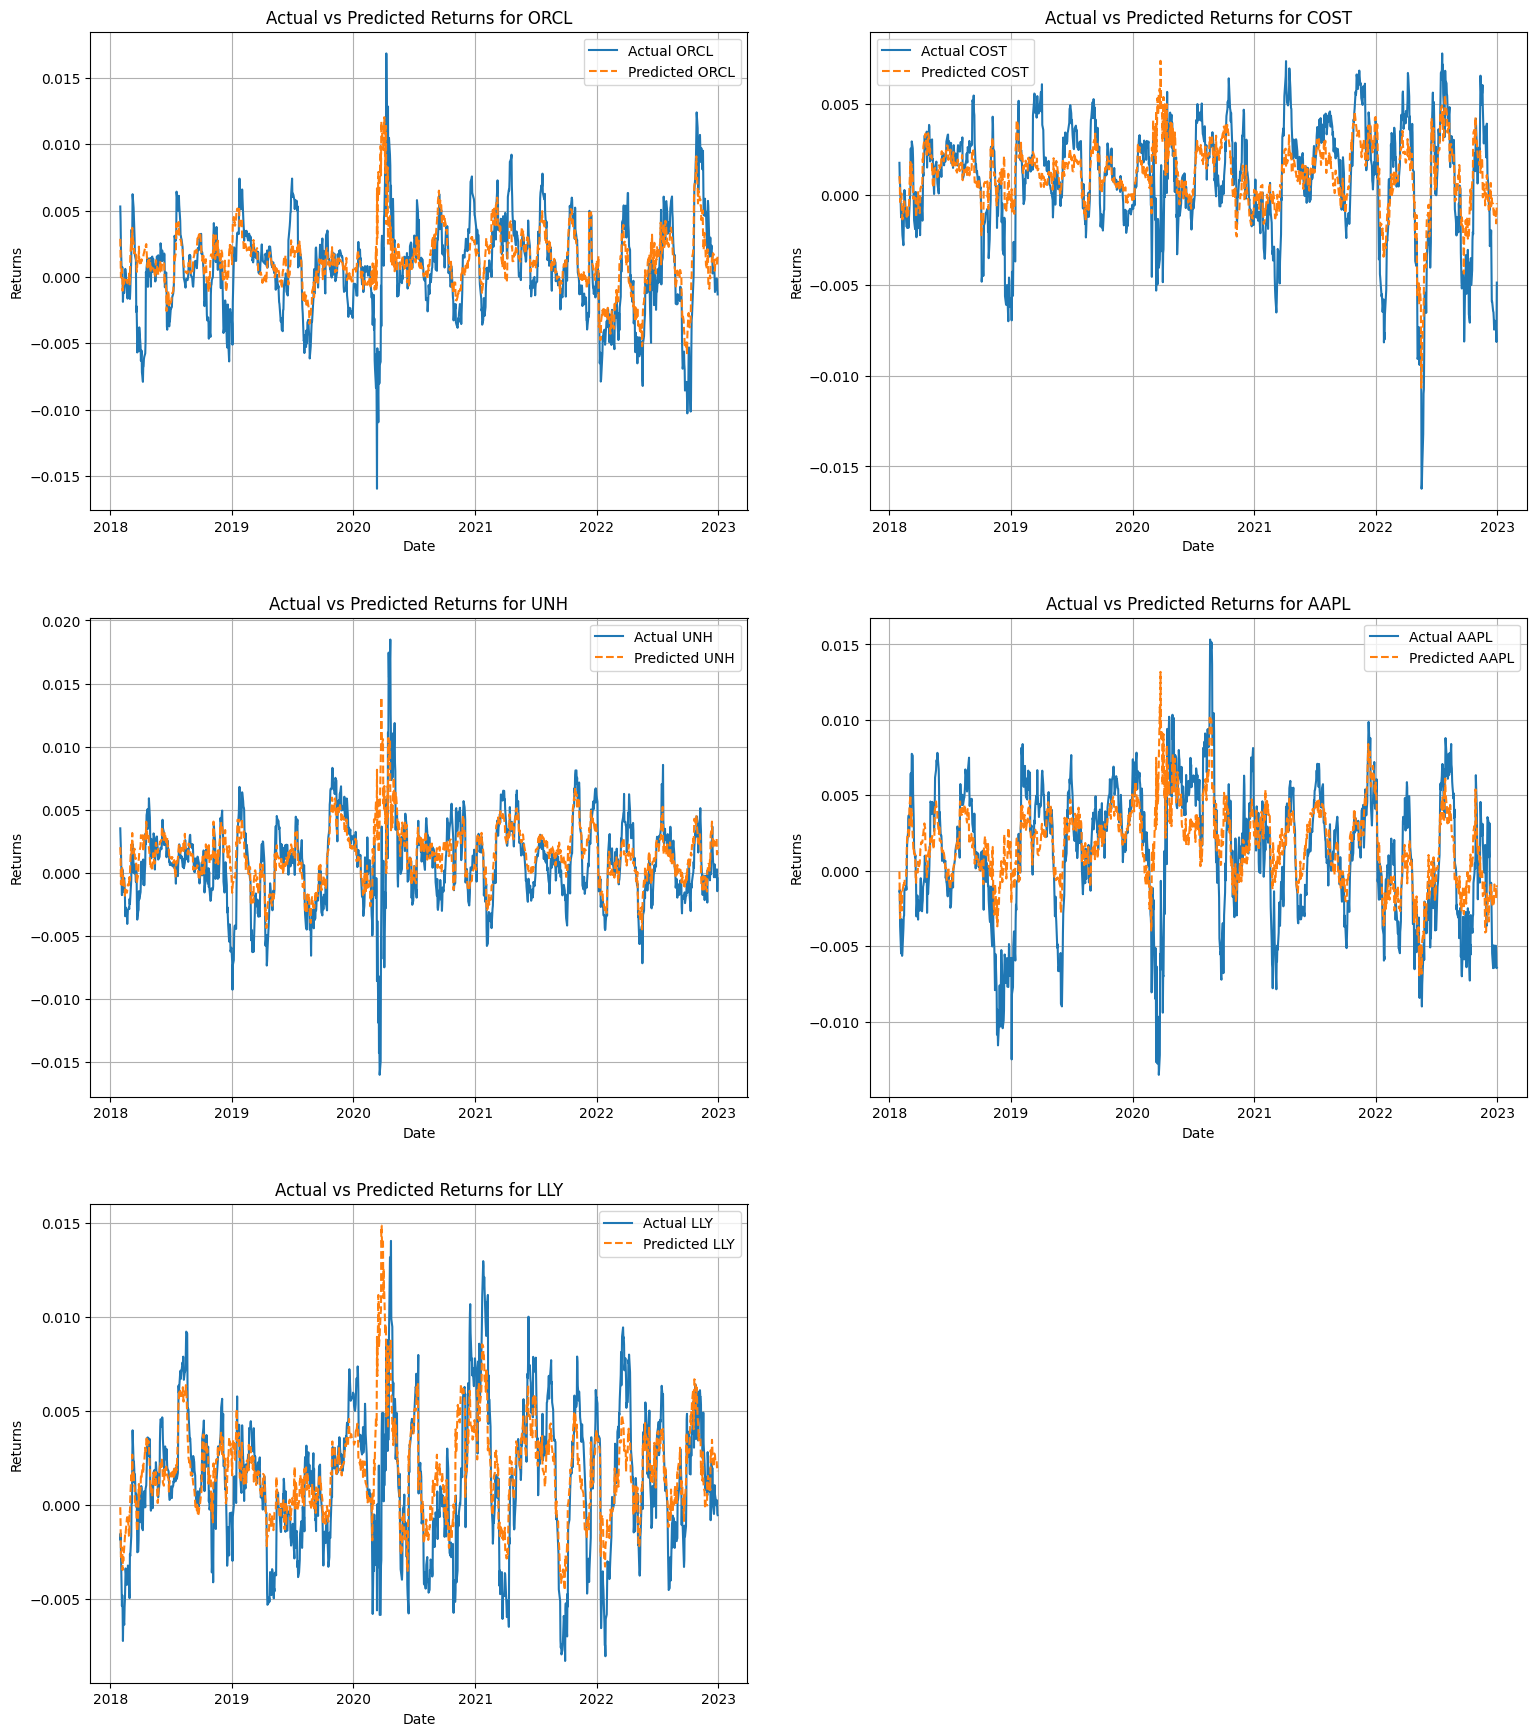

In [6]:
import matplotlib.pyplot as plt

window_size = 20

plt.figure(figsize=(16, 18))

for i, stock in enumerate(top_5_stocks):
    plt.subplot(3, 2, i + 1)
    
    dates = returns.index
    actual_returns = selected_returns[stock]
    predicted_returns = selected_predicted_returns[stock]
    
    smooth_actual = actual_returns.rolling(window=window_size).mean()
    smooth_predicted = predicted_returns.rolling(window=window_size).mean()
    
    plt.plot(dates, smooth_actual, label=f'Actual {stock}', linestyle='-')
    plt.plot(dates, smooth_predicted, label=f'Predicted {stock}', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Returns')
    plt.title(f'Actual vs Predicted Returns for {stock}')
    plt.legend()
    plt.grid(True)
    

plt.tight_layout(pad=3.0)
plt.show()    

In [7]:
def portfolio_performance(weights, returns):
    portfolio_return = np.sum(weights * returns.mean()) * 252
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    return portfolio_return, portfolio_volatility

def negative_sharpe_ratio(weights, returns, risk_free_rate=0.01):
    p_return, p_volatility = portfolio_performance(weights, returns)
    return - (p_return - risk_free_rate) / p_volatility

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

bounds = tuple((0, 1) for _ in range(len(top_5_stocks)))

initial_guess = [1. / len(top_5_stocks)] * len(top_5_stocks)


In [8]:
result = minimize(negative_sharpe_ratio, initial_guess, args=(selected_returns,),
                  method='SLSQP', bounds=bounds, constraints=constraints)

optimal_weights = result.x

print("Optimal weights for the selected stocks:")
print(dict(zip(top_5_stocks, optimal_weights)))

optimal_return, optimal_volatility = portfolio_performance(optimal_weights, selected_returns)
sharpe_ratio = (optimal_return-0.01)/optimal_volatility

print("Expected annual return:", optimal_return)
print("Expected annual volatility:", optimal_volatility)
print("Sharpe Ratio:", sharpe_ratio)

Optimal weights for the selected stocks:
{'ORCL': 0.0, 'COST': 0.25964956943181, 'UNH': 0.016083211468953144, 'AAPL': 0.16342783477737882, 'LLY': 0.5608393843218581}
Expected annual return: 0.3083767220699594
Expected annual volatility: 0.2348414028946212
Sharpe Ratio: 1.2705456465180802


/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


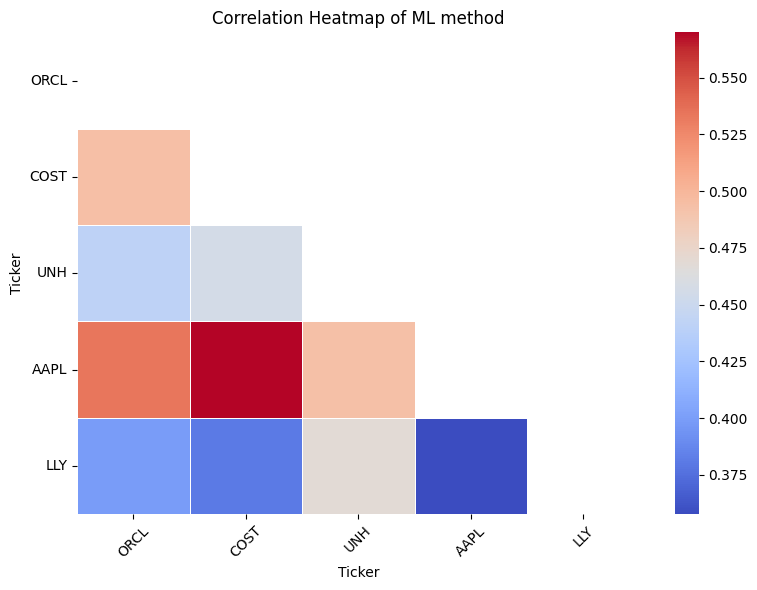

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = selected_returns.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(8, 6))

sns.heatmap(corr,mask = mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title('Correlation Heatmap of ML method')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()

plt.show()

In [10]:
bounds_no_ml = tuple((0, 1) for _ in range(len(tickers)))

no_ml_initial_guess = [1. / len(tickers)] * len(tickers) 
result_without_random_forest = minimize(negative_sharpe_ratio, no_ml_initial_guess, args=(returns),
                  method='SLSQP', bounds=bounds_no_ml, constraints=constraints)

optimal_weights_no_ml = result_without_random_forest.x

print("Optimal weights for the selected stocks:")
print(dict(zip(tickers, optimal_weights_no_ml)))

optimal_return_no_ml, optimal_volatility_no_ml = portfolio_performance(optimal_weights_no_ml, returns)
sharpe_ratio_no_ml = (optimal_return_no_ml-0.01)/optimal_volatility_no_ml

print("Expected annual return:", optimal_return_no_ml)
print("Expected annual volatility:", optimal_volatility_no_ml)
print("Sharpe Ratio:", sharpe_ratio_no_ml)

Optimal weights for the selected stocks:
{'AAPL': 0.0, 'MSFT': 0.0, 'GOOGL': 3.651185281839993e-16, 'AMZN': 2.1181899173704807e-15, 'TSLA': 0.0, 'META': 0.0, 'NVDA': 0.0, 'JNJ': 0.0, 'V': 9.246751794526737e-16, 'WMT': 0.09041777821552546, 'JPM': 2.7475448316186136e-15, 'PG': 0.07045142218120601, 'MA': 9.368453790583264e-16, 'UNH': 2.3291230480389298e-15, 'DIS': 0.0, 'PYPL': 0.0, 'BAC': 1.6037275456585783e-15, 'VZ': 0.0, 'ADBE': 0.0, 'NFLX': 1.4129267111824355e-17, 'PFE': 3.2915834447313762e-15, 'KO': 0.0, 'INTC': 0.0, 'CMCSA': 0.3744497204749439, 'PEP': 0.0, 'CSCO': 0.2603060432380624, 'MRK': 0.0, 'T': 0.0, 'XOM': 5.624007600098461e-15, 'NKE': 0.04461768678945267, 'WFC': 0.0, 'ORCL': 0.0, 'ACN': 0.04175341936638583, 'LLY': 1.3728257096805053e-15, 'TMO': 0.0, 'ABBV': 0.0, 'COST': 0.0, 'AVGO': 0.0, 'MDT': 0.0, 'QCOM': 0.0, 'TXN': 0.0, 'NEE': 4.902927812972282e-15, 'HON': 0.0, 'UNP': 1.4850934510303876e-15, 'AMGN': 0.03488418077142758, 'PM': 0.08311974896299486, 'UPS': 3.319082600936884e-

In [11]:
import pandas as pd

df_tickers = pd.DataFrame(tickers)
df_weights = pd.DataFrame(optimal_weights_no_ml)
df_tickers = df_tickers.rename(columns={df_tickers.columns[0]: 'ticker'})
df_weights = df_weights.rename(columns={df_weights.columns[0]: 'weight'})


In [12]:
merged_df = pd.concat([df_tickers, df_weights], axis=1)

filtered_df = merged_df[merged_df['weight'] > 0.01]
print(filtered_df[['ticker', 'weight']])

total_weight = filtered_df['weight'].sum()

# Print the total weight
print(f"Total weight: {total_weight}")


   ticker    weight
9     WMT  0.090418
11     PG  0.070451
23  CMCSA  0.374450
25   CSCO  0.260306
29    NKE  0.044618
32    ACN  0.041753
44   AMGN  0.034884
45     PM  0.083120
Total weight: 0.9999999999999988


In [13]:
columns_to_select = merged_df.loc[merged_df['weight'] > 0.01, 'ticker'].tolist()



selected_columns_no_ml = returns[columns_to_select]

/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


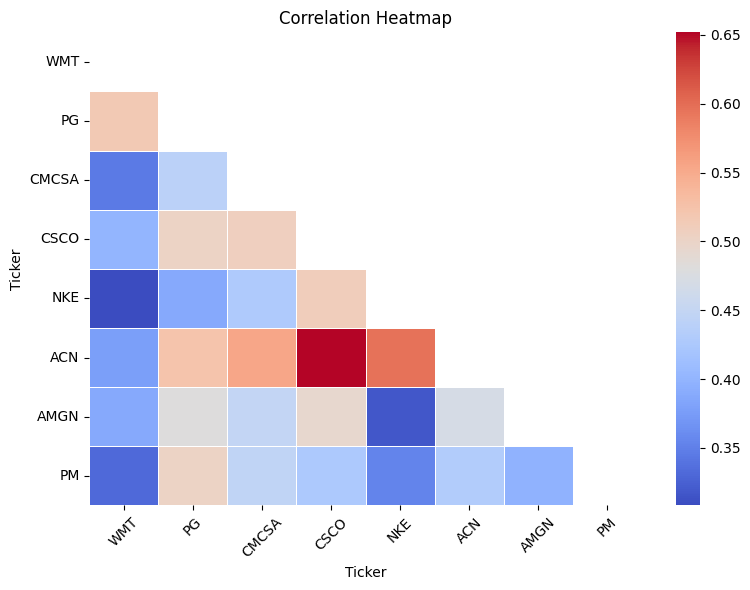

In [14]:
corr_no_ml = selected_columns_no_ml.corr()

mask_no_ml = np.triu(np.ones_like(corr_no_ml, dtype=bool))

plt.figure(figsize=(8, 6))

sns.heatmap(corr_no_ml,mask = mask_no_ml, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title('Correlation Heatmap')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()

plt.show()